In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Define the path to your image folder
image_folder = "dataset"

# Initialize empty lists to store the image paths and labels
image_paths = []
labels = []

# Traverse through the folder and its subfolders to collect the image paths and labels
for root, dirs, files in os.walk(image_folder):
    for file in files:
        image_paths.append(os.path.join(root, file))
        labels.append(os.path.basename(root))

# Load and resize the images
image_data = []
image_size = (224, 224)  # Adjust the size as per your model's input requirements

for path in image_paths:
    image = Image.open(path)
    image = image.resize(image_size)
    image = np.array(image)  # Convert image to numpy array
    image_data.append(image)

# Convert the labels into one-hot encoded vectors
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

# Encode labels as integers
integer_encoded = label_encoder.fit_transform(labels)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

# One-hot encode integers
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# Create a dataframe combining the image data and labels
df = pd.DataFrame({"image": image_data, "label": onehot_encoded.tolist()})

# Split the dataframe into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42)

# Preprocess the image data
X_train_processed = np.stack(X_train.values)
X_val_processed = np.stack(X_val.values)

# Normalize the pixel values to the range of 0 to 1
X_train_processed = X_train_processed / 255.0
X_val_processed = X_val_processed / 255.0

# Convert labels to NumPy arrays
y_train_processed = np.array(list(y_train))
y_val_processed = np.array(list(y_val))



In [12]:
from keras.layers import Input,Dropout
from tensorflow.keras import Model


#the convolution procedures has three repeated steps for 3 times (conv2D, Maxpooling,Dropout)
#1st convolution 
input_data = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation="relu")(input_data) #ReLU takes any value greater than 0 without change; otherwise, the value is 0
x = MaxPooling2D(pool_size = (4, 4), strides=(4, 4))(x) # takes the max value of each 4x4 matrix 
x = Dropout(0.25)(x) #reduces the overfitting and the large complex number in NN 
#2nd convolution 
x = Conv2D(32, (3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size = (2, 2))(x)
x = Dropout(0.3)(x)
#3rd convolution 
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
#fully connected layer formed by feature maps were fabricated by the former convolution
x = Flatten()(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(26, activation = 'sigmoid')(x) #sigmoid range is [0,1] for reducing the loss value during the training 
cnn = Model(inputs=input_data, outputs=output)
# Compiling the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#adam can handle sparse gradients on noisy problems
#cross entropy measures the difference between two events or probabilities and it is binary to set 0 withmask and 1 withoutmask
cnn.summary()
epochs = 100  
batch_size = 32
cnn.fit(X_train_processed, y_train_processed, validation_data=(X_val_processed, y_val_processed), 
          batch_size=batch_size, epochs=epochs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 55, 55, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 53, 53, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 26, 26, 32)       0         
 g2D)                                                      

38/38 [==============================] - 11s 296ms/step - loss: 0.0060 - accuracy: 0.9800 - val_loss: 0.2170 - val_accuracy: 0.5467
Epoch 98/100
38/38 [==============================] - 13s 331ms/step - loss: 0.0072 - accuracy: 0.9783 - val_loss: 0.2176 - val_accuracy: 0.5600
Epoch 99/100
38/38 [==============================] - 12s 310ms/step - loss: 0.0071 - accuracy: 0.9783 - val_loss: 0.2135 - val_accuracy: 0.5400
Epoch 100/100
38/38 [==============================] - 11s 303ms/step - loss: 0.0063 - accuracy: 0.9825 - val_loss: 0.2298 - val_accuracy: 0.5433


In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions on the test data
y_pred = model.predict(X_val_processed)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_val_processed.argmax(axis=1), y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Calculate accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print("Accuracy:", accuracy)

# Calculate F1 score and recall
report = classification_report(y_val_processed.argmax(axis=1), y_pred_classes)
print("Classification Report:")
print(report)

10/10 [==============================] - 1s 72ms/step
Confusion Matrix:
[[53  0  0  2  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0 28  0  0  2  0  3  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [11  0  0  6  0  1  0  0  0  3  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  4  0  0  3  1  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  3  6  0  1  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0
   0  0]
 [ 0  5  0  0  0  0  2  0  0  0  2  0  0  0  2  0  0  0  0  0  0  0  0  1
   0  0]
 [ 0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  2  0  0  1  3  0  0  1  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  0  0  0  0  8  0  1  0  1  1  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  1  0  2  1  0  1  0  0  0  3  0  0  0  2  2  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  

C:\Users\Ahmed Mohamed\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed Mohamed\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ahmed Mohamed\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

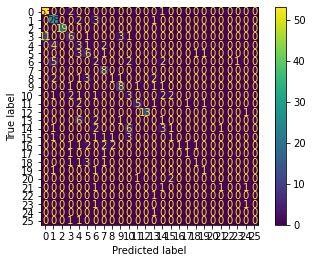

In [15]:
from sklearn.metrics import  ConfusionMatrixDisplay,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,classification_report
from matplotlib import pyplot as plt
%matplotlib inline
ConfusionMatrixDisplay.from_predictions(y_val_processed.argmax(axis=1), y_pred_classes)
plt.show()

In [ ]:
def predict_model(model,image):
    return model.predict(image)